In [93]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
from scipy.ndimage import rotate

In [20]:
# Read data file
df = pd.read_csv('data/ch2_train_center_cam.csv')

## Check out an image

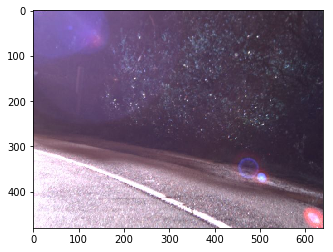

In [100]:
img = cv.imread('data/ch2_train_center/1479424610768911885.png', 1)
plt.imshow(img)

In [68]:
# Check out associated label
data = df.loc[df['filename']=='center/1479424610768911885.png']
steering_angle = data.angle.values.squeeze()
print('label = ', steering_angle)

label =  41.067423994354094


# Image Utils

In [98]:
def imgCenterCrop(img, crop_size):
    """
    Crop source img
    
    :param img: source img
    
    :param crop_size: ints tuple
        size of cropped img
        
    :return: cropped img
    """
    crop_height, crop_width = crop_size 
    w_l = np.int32((img.shape[1] - crop_width) / 2)
    return img[img.shape[0] - crop_height:, w_l: w_l + crop_width]


def imgRandomFlip(img, steering_angle, flipping_prob=0.5):
    """
    Flip a coin, if head -> flip the image. If the image is flipped
    the steering angle is flipped sign
    
    :param img: original image
    
    :param steering_angle: original steering angle
    
    :param flipping_prob:
    
    :return:
        (flipped) image, (flipped) steering angle
    
    """
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(img), -1 * steering_angle
    else:
        return img, steering_angle
    

def imgRandomAdjustGamma(img):
    """
    Randomly apply gamma correction on img to adjust its brightness
    
    :param img: source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8") 
    
    # apply gamma correction using lookup table
    return cv.LUT(img, table)


def imgRandomShear(img, steering_angle, shear_range=200):
    """
    Source:  https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

    :param img: source img
    
    :param steering_angle: associate steering_angle
    
    :param shear_range: random shear between [-shear_range, shear_range + 1]

    :return:
        sheared img & sheared steering angle
    """
    if len(img.shape) > 2:
        rows, cols, ch = img.shape
    else:
        rows, cols = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv.getAffineTransform(pts1, pts2)
    img = cv.warpAffine(img, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return img, steering_angle


def imgRandomRotate(img, steering_angle, max_rotation=15):
    """
    Rotate input image
    
    :param img: source img
    
    :param steering_angle: assoc. steering_angle
    
    :return:
        Rotated img & rotated steering angle
    """
    rot_angle = np.random.uniform(-max_rotation, max_rotation + 1) * np.pi / 180
    return rotate(img, rot_angle, reshape=False), steering_angle - rot_angle


def imgPreprocess(img, steering_angle, crop_size=(300, 400), shear_prob=0.75, resize=(128, 128)):
    """
    Apply all random treatment on source image
    
    :return:
        pre-processed img & its associate steering angle
    """
    # crop 
    img = imgCenterCrop(img, crop_size)
    
    # adjust brightness
    img = imgRandomAdjustGamma(img)
    
    # randomly flip
    img, steering_angle = imgRandomFlip(img, steering_angle)
    
    # randomly rotate
    img, steering_angle = imgRandomRotate(img, steering_angle)
    
    # randomly shear
    head = bernoulli.rvs(shear_prob)
    if head:
        img, steering_angle = imgRandomShear(img, steering_angle)
    
    return cv.resize(img, resize), steering_angle

### Test imgCenterCrop

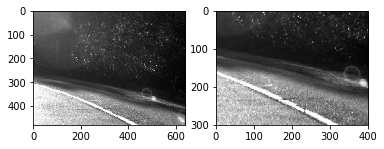

In [58]:
crop_img = imgCenterCrop(img)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(crop_img, cmap='gray')

### Test flip image

fipped !!!!!!!!!!!!


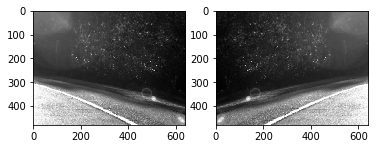

In [80]:
flip_img, flip_angle = imgRandomFlip((img), steering_angle)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(flip_img, cmap='gray')

In [76]:
print(flip_angle)

-41.067423994354094


### Test gamma correction

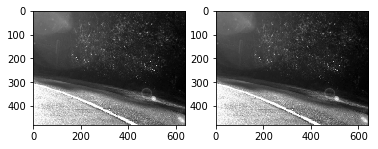

In [84]:
gamma_img = imgRandomAdjustGamma(img)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(gamma_img, cmap='gray')

### Test shear

shear_steering_angle:  41.264776123788046


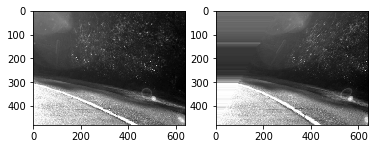

In [92]:
shear_img, shear_steering_angle = imgRandomShear(img, steering_angle)
print("shear_steering_angle: ", shear_steering_angle)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(shear_img, cmap='gray')

### Test rotate

rot_steering_angle:  41.509991563431484


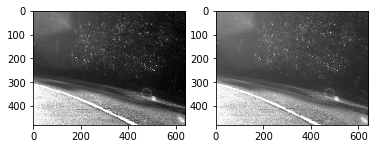

In [95]:
rot_img, rot_steering_angle = imgRandomRotate(img, steering_angle)
print("rot_steering_angle: ", rot_steering_angle)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(rot_img, cmap='gray')

new_steering_angle:  -41.62129595352138


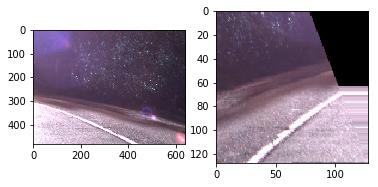

In [104]:
new_img, new_steering_angle = imgPreprocess(img, steering_angle)

print("new_steering_angle: ", new_steering_angle)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(new_img, cmap='gray')